In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class Palanthir(object):

    def __init__(self, input):
        """Initiates a Palanthir-class on-top a Pandas Dataframe. The class-attributes describes the overall structure and composition of the data"""
        self.input_data = input
        self.output = self.input_data.copy(deep=True)
        self.observations = len(self.output)
        self.features = list(self.output)
        self.features_num = list(self.output.loc[:, self.output.dtypes != object])
        self.features_cat = list(self.output.loc[:, self.output.dtypes == object])
        self.train_subset = []
        self.test_subset = []
        self.current_version = 0
        self.transformation_history = [dict(version=0,transformation='input',result=self.input_data,pipeline=Pipeline([]))]

    def update_attributes(self):
        self.observations = len(self.output)
        self.features = list(self.output)
        self.features_num = list(self.output.loc[:, self.output.dtypes != object])
        self.features_cat = list(self.output.loc[:, self.output.dtypes == object])

    def update_history(self, step=None, snapshot=None,text=None,transformer=None):
        pipelineSteps = self.transformation_history[-1].get('pipeline').steps + [text,transformer]
        updatedPipeline = Pipeline(pipelineSteps)
        self.current_version += 1
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=step
                ,result=snapshot
                ,pipeline=updatedPipeline
            )
        )

    def restore(self, toVersion=None):
        versionCheckpoint = (self.current_version - 1) if toVersion == None else toVersion
        self.current_version = versionCheckpoint
        self.output = self.transformation_history[versionCheckpoint].get('result')
        self.update_attributes()
        self.transformation_history.append(
            dict(
                version=self.current_version
                ,transformation=f"Restored to version {self.current_version}"
                ,result=self.transformation_history[self.current_version].get('result')
                ,pipeline=self.transformation_history[self.current_version].get('pipeline')
            )
        )

    def summarize(self):
        """Prints the info, description and any missing value-counts for the class"""
        dataset = self.output
        return print(
            "Info: ", dataset.info(),
            "Description: ", dataset.describe(),
            "Missing values: ", dataset.isna().sum()
        )

    def random_split(self, test_size, store=True):
        """Uses the SKLearn Train_Test_Split to divide the dataset into random training and test subset"""
        dataset = self.output
        from sklearn.model_selection import train_test_split
        train, test = train_test_split(dataset, test_size=test_size, random_state=42)
        if store:
            self.train_subset, self.test_subset = [train], [test]
        return train, test

    def stratified_split(self, cols, store=True):
        """Uses the SKLearn StratigiesShuffleSplit to divide the dataset into stratified training and test subset"""
        dataset = self.output
        from sklearn.model_selection import StratifiedShuffleSplit
        split = StratifiedShuffleSplit(n_split=1, test_size=0.2, random_state=42)
        for train_index, test_index in split.split(dataset, dataset[cols]):
            strat_train_set = dataset.loc[train_index]
            strat_test_set = dataset.loc[test_index]
        if store:
            self.train_subset, self.test_subset = [strat_train_set], [strat_test_set]
        return strat_train_set, strat_test_set

    def PCA(self, n_components=0.80, store=True):
        dataset = self.output[self.features_num]
        from sklearn.decomposition import PCA
        PCAtransformer = PCA(n_components=n_components).fit(dataset)
        pca_data = PCAtransformer.transform(dataset)
        output_df = pd.DataFrame(pca_data, columns=["PCA_" + str(col + 1) for col in range(pca_data.shape[1])],index=dataset.index)
        if store:
            self.output = output_df
            self.update_attributes()
            self.update_history(step="Performed Principal Component Analysis",snapshot=self.output,text='pca',transformer=PCAtransformer)
        explained_variance = PCA().fit(dataset).explained_variance_ratio_
        cumsum = np.cumsum(explained_variance)
        print(cumsum)
        plt.plot(["PCA" + str(num) for num in range(1, len(cumsum) + 1)], cumsum)
        plt.show()
        return output_df

    def fill_nulls(self, strategy="median", store=True):
        """Uses the SKLearn SimpleImputer to fill out any missing values in the numerical features of the dataset"""
        dataset = self.output[self.features_num]
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy=strategy).fit(dataset)
        imputed_data = imputer.transform(dataset)
        output_df = pd.DataFrame(imputed_data, columns=dataset.columns, index=dataset.index)
        if store:
            self.output[self.features_num] = output_df
            self.update_attributes()
            self.update_history(step="Filled nulls",snapshot=self.output,text='impute',transformer=imputer)
        return output_df

    def encode_order(self, store=True):
        """Uses the SKLearn OrdinalEncoder to order any categorical features of the dataset"""
        dataset = self.output[self.features_cat]
        from sklearn.preprocessing import OrdinalEncoder
        encoder = OrdinalEncoder().fit(dataset)
        encoded_data = encoder.transform(dataset)
        output_df = pd.DataFrame(encoded_data, columns=dataset.columns, index=dataset.index)
        if store:
            self.output[self.features_cat] = output_df
            self.update_attributes()
            self.update_history(step="Encoded order of categorial features",snapshot=self.output,text='ordinal',transformer=encoder)
        return output_df

    def make_dummies(self, store=True):
        """Uses the SKLearn OneHotEncoder to turn categorical features of the dataset into dummy-variables"""
        dataset = self.output[self.features_cat]
        from sklearn.preprocessing import OneHotEncoder
        encoder = OneHotEncoder().fit(dataset)
        new_column_names = encoder.get_feature_names_out(dataset.columns)
        dummy_data = encoder.transform(dataset).toarray()
        dummy_data_df = pd.DataFrame(dummy_data, columns=[name for name in new_column_names], index=dataset.index)
        output_df = pd.merge(self.output[self.features_num], dummy_data_df, left_index=True, right_index=True)
        if store == True:
            self.output = output_df
            self.update_attributes()
            self.update_history(step="Turned categorical features into dummy variables",snapshot=self.output,text='onehot',transformer=encoder)
        return output_df

    def scale(self, strategy:str, store=True):
        """Uses the SKLearn StandardScaler or MinMaxScaler to scale all numerical features of the dataset"""
        dataset = self.output[self.features_num]
        from sklearn.preprocessing import StandardScaler, MinMaxScaler
        if strategy=="Standard":
            scaler = StandardScaler().fit(dataset)
        elif strategy=="MinMax":
            scaler = MinMaxScaler().fit(dataset)
        else:
            print('Not a proper scaler')
        output_df = scaler.transform(dataset)
        if store:
            self.output[self.features_num] = output_df
            self.update_attributes()
            self.update_history(step=f"""Scaled feature-values using {'Standard-scaler' if strategy=='Standard' else 'MinMax-scaler'}""",snapshot=self.output,text='scaler',transformer=scaler)
        return output_df

    def cluster(self, max_k=10, store=True):
        """Uses the SKLearn KMeans to cluster the dataset"""
        dataset = self.output
        from sklearn.cluster import KMeans
        from matplotlib import pyplot
        from sklearn.metrics import silhouette_score
        kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(dataset) for k in range(1, max_k + 1)]
        silhouettes = [silhouette_score(dataset, model.labels_) for model in kmeans_per_k[1:]]
        best_k = silhouettes.index(max(silhouettes)) + 2
        plt.plot(range(2, max_k + 1), silhouettes)
        plt.xlabel("KMeans")
        plt.ylabel("Silhouette-score")
        plt.show()
        print("Best silhouette is obtained with k as: ", best_k)
        if store:
            self.output["Cluster"] = ["Cluster " + str(i) for i in KMeans(n_clusters=best_k, random_state=42).fit_predict(dataset)]
            self.update_attributes()
            self.update_history(step="Added Cluster-label as column to dataset",snapshot=self.output)
        return self.output

    def construct_pipeline(self):
        """Uses the SKLearn Pipeline and ColumnTransformer to construct a pipeline of transformations on the dataset - including filling out zeroes, scaling and dummifying"""
        dataset = self.output
        from sklearn.pipeline import Pipeline
        from sklearn.compose import ColumnTransformer
        num_columns = []
        cat_columns = []
        num_pipeline = Pipeline([
            ("imputer", self.fill_nulls()),
            ("scaler", self.scale()),
        ])
        cat_pipeline = Pipeline([
            ("dummy", self.make_dummies()),
        ])
        full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_columns),
            ("cat", cat_pipeline, cat_columns),
        ])
        self.output = full_pipeline.fit_transform(dataset)
        return self.output

    def cross_validate(self, model, x, y, score_measure="neg_mean_squared_error", folds=10):
        """Uses the SKLearn Cross_Val_Score to cross-validate one/several models on the training subset"""
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(model, x, y, scoring=score_measure, cv=folds)
        return scores

    def full_analysis(self, model):
        """Conducts a full data-analysis pipeline on the dataset, including model training, evaluation and tuning"""
        dataset = self.output
        X_train, X_test, Y_train, Y_test = self.random_split(dataset)

        sqrt_scores = np.sqrt(-self.cross_validate(model, X_train, Y_train, score_measure="neg_mean_squared_error", folds=10))
        print(
            "RMSE-scores: ", sqrt_scores,
            "RMSE-mean: ", sqrt_scores.mean(),
            "RMSE-std: ", sqrt_scores.std()
        )

In [313]:
dir = 'C:/Users/JesperFrederiksen/PycharmProjects/ML-code/datasets/housing/housing.csv'
df = pd.read_csv(dir)

In [314]:
pal = Palanthir(df)

In [315]:
pal.transformation_history[0].get('pipeline')

Pipeline(steps=[])

In [316]:
pal.make_dummies()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,0.0,1.0,0.0,0.0,0.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,0.0,1.0,0.0,0.0,0.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,0.0,1.0,0.0,0.0,0.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,0.0,1.0,0.0,0.0,0.0


In [317]:
pal.current_version

1

In [318]:
pal.transformation_history[1].get('pipeline')

Pipeline(steps=['onehot', OneHotEncoder()])

In [319]:
pal.fill_nulls()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,0.0,1.0,0.0,0.0,0.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,0.0,1.0,0.0,0.0,0.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,0.0,1.0,0.0,0.0,0.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,0.0,1.0,0.0,0.0,0.0


In [320]:
pal.current_version

2

In [321]:
pal.transformation_history[-1].get('pipeline')

Pipeline(steps=['onehot', OneHotEncoder(), 'impute',
                SimpleImputer(strategy='median')])

[0.99952887 0.99997786 0.99999747 0.99999974 0.99999999 1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


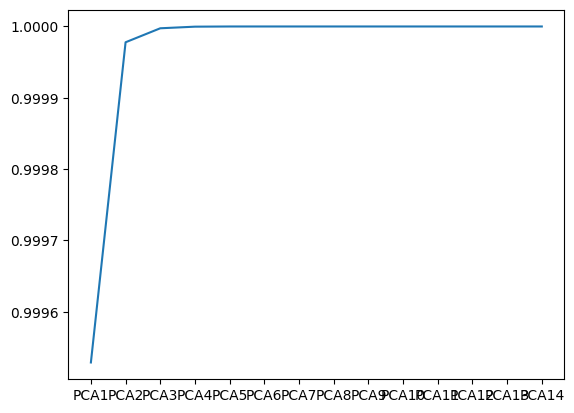

,PCA_1
0,245739.032370
1,151655.014337
2,145240.832269
3,134440.380387
4,135341.288142
...,...
20635,-128757.782709
20636,-129760.204756
20637,-114556.331803
20638,-122157.274188


In [322]:
pal.PCA()

In [323]:
pal.current_version

3

In [324]:
pal.transformation_history[-1].get('pipeline')

Pipeline(steps=['onehot', OneHotEncoder(), 'impute',
                SimpleImputer(strategy='median'), 'pca',
                PCA(n_components=0.8)])

In [325]:
pal.restore()

In [326]:
pal.current_version

2

In [327]:
pal.transformation_history[-1].get('pipeline')

Pipeline(steps=['onehot', OneHotEncoder(), 'impute',
                SimpleImputer(strategy='median')])

In [328]:
pal.restore(toVersion=0)

In [329]:
pal.current_version

0

In [330]:
pal.transformation_history[-1].get('pipeline')

Pipeline(steps=[])

In [335]:
pal.restore(toVersion=3)

In [336]:
pal.current_version

3

In [337]:
pal.transformation_history[-1].get('pipeline')

Pipeline(steps=['onehot', OneHotEncoder(), 'impute',
                SimpleImputer(strategy='median'), 'pca',
                PCA(n_components=0.8)])